In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.ndimage as nd
from tensorflow.examples.tutorials.mnist import input_data


%matplotlib inline

plt.rcParams["image.cmap"] = "gist_gray"

In [2]:
tf.reset_default_graph()

In [3]:
print(tf.__version__)

0.12.0


In [4]:
# --- locations of pictures
dpath  = "pictures"
# training_path_full = "/Users/geoffperrin/Desktop/CUSP/capstone/computer_vision/training_pictures"
training_path = 'training_pictures'

In [5]:
os.getcwd()

'/Users/geoffperrin/Desktop/CUSP/capstone/computer_vision'

In [6]:
# -- get path to images
stpath = os.path.join(training_path, "*.jpg")
stlist = sorted(glob.glob(stpath))
nstamp = len(stlist)

In [7]:
x = nd.imread('training_pictures/defect_pos_70.jpg', mode='L')
x.shape

(50, 50)

In [8]:
# -- set a shuffle index
np.random.seed(314)
sind = np.random.rand(nstamp).argsort()

# -- read the postage stamps and shuffle
image_list = []
image_list.append([nd.imread(i)[1:-1, 1:-1] for i in stlist])

#read in as grayscale!
image_list_shuffled = np.array([nd.imread(i, mode='L')[1:-1, 1:-1] for i in stlist])[sind]
stamps = np.array([nd.imread(i, mode='L')[1:-1, 1:-1].flatten() for i in stlist])[sind]

# -- set the labels
labels = np.array([[1.0, 0.0] if "pos" in i  else [0.0, 1.0] for i in stlist]).astype(np.float32)[sind]

In [9]:
nstamp = len(stlist)
npix   = stamps.shape[1]
nside  = int(np.sqrt(npix))

In [10]:
len(stamps[1])

2304

In [11]:
print(nstamp, npix, nside)

(479, 2304, 48)


### Cracks!

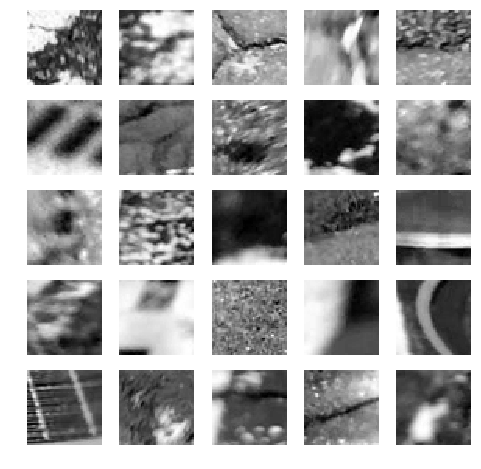

In [12]:
nax = 5
fig, ax = plt.subplots(nax, nax, figsize=(8, 8))
[ax[ii // nax, ii % nax].axis("off") for ii in range(nax * nax)]
[ax[ii // nax, ii % nax].imshow(image_list_shuffled[labels[:, 0] == 1][ii]) for ii in range(nax * nax)]
fig.canvas.draw()

### Smooth!

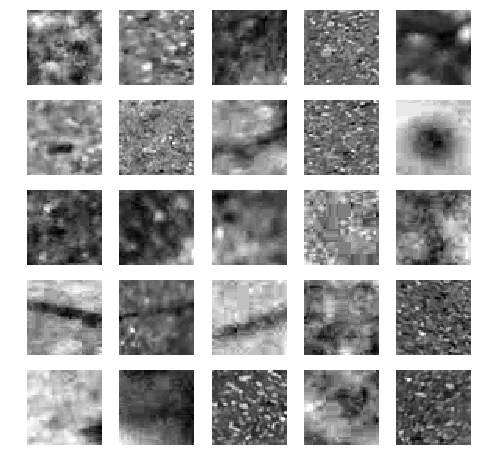

In [13]:
nax = 5
fig, ax = plt.subplots(nax, nax, figsize=(8, 8))
[ax[ii // nax, ii % nax].axis("off") for ii in range(nax * nax)]
[ax[ii // nax, ii % nax].imshow(image_list_shuffled[labels[:, 0] == 0][ii]) for ii in range(nax * nax)]
fig.canvas.draw()

### Building the CNN
The data is now in **exactly** the same form as the MNIST data was, and so we can apply the same model:

In [14]:
npix

2304

In [15]:
# -- prototype weight and bias variables
def weight_variable(shape):
    """ Initialize a variable with Gaussian noise."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    """ Initialize a variable with a constant value."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


# -- prototype convolutional and pooling functions
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding="SAME")

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")


# -- define data prototypes and reshape input
x       = tf.placeholder(tf.float32, shape=[None, npix], name='x')
y_      = tf.placeholder(tf.float32, shape=[None, 2], name='y_') # only two possibilities car vs not car
x_image = tf.reshape(x, [-1, 48, 48, 1], name='x_image') # last channel is color channel


# -- first layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)


# -- second layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)


# -- fully connected layer
W_fc1        = weight_variable([12 * 12 * 64, 1024]) # this is why 48x48 instead of 50x50
b_fc1        = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 12 * 12 * 64])
h_fc1        = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# -- dropout
keep_prob  = tf.placeholder(tf.float32, name='keep_prob')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)


# -- output layer
W_fc2  = weight_variable([1024, 2])
b_fc2  = bias_variable([2])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [16]:
y_

<tf.Tensor 'y_:0' shape=(?, 2) dtype=float32>

In [17]:
y_conv

<tf.Tensor 'add_3:0' shape=(?, 2) dtype=float32>

---

### Training the CNN

Again, we can train exactly as before.  The only difference is that we need a training and testing set, so let's do a 70/30 split.

In [18]:
ntrain = int(0.7 * nstamp)
ntest  = nstamp - ntrain

st_train = stamps[:ntrain]
st_test  = stamps[ntrain:]
lb_train = labels[:ntrain]
lb_test  = labels[ntrain:]

In [19]:
# -- define the loss
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

# -- define the optimizer
train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

# -- define prediction and accuracy
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

Now let's train:

In [20]:
saver = tf.train.Saver()

In [ ]:
mdir = 'checkpoints/'
mpath = os.path.join(mdir, 'pothole')

In [ ]:
nepoch   = 10
batch_sz = 50
nstep    = ntrain // batch_sz
loss     = np.zeros(nepoch * nstep)

np.random.seed(1519)

with tf.Session() as sess:
    # -- initialize **ALL** of those weights and biases
    sess.run(tf.global_variables_initializer())

    # -- loop through epochs
    for epoch in range(nepoch):

        rind = np.random.rand(ntrain).argsort()
        st_train = st_train[rind]
        lb_train = lb_train[rind]
        
        for ii in range(nstep):
            # get the next minibatch of images
            lo = batch_sz * ii
            hi = batch_sz *(ii + 1)
            batch = [st_train[lo:hi], lb_train[lo:hi]]

            # alert the user how the training is going after ever 100 epochs
            if ii % 1 == 0:
                acc_in = {x:batch[0], y_:batch[1], keep_prob:1.0} # don't use dropout for accuracy estimate
                train_accuracy = accuracy.eval(feed_dict=acc_in)
                print("epoch,step {0:2},{1:2} - training accuracy {2}".format(epoch, ii, train_accuracy))

            # take a gradient descent step
            mod_in = {x:batch[0], y_:batch[1], keep_prob:0.5}
            train_step.run(feed_dict=mod_in)
            loss[epoch * nstep + ii] = sess.run(cross_entropy, mod_in)

    # -- print the final accuracy on the test data
    test_in = {x:st_test, y_:lb_test, keep_prob:1.0} # don't use dropout for testing
    test_accuracy = accuracy.eval(feed_dict=test_in)
    print("test accuracy {0}".format(test_accuracy))
    
    saver.save(sess, save_path=mpath)
    meta_graph_def = tf.train.export_meta_graph(filename=mpath)

epoch,step  0, 0 - training accuracy 0.340000003576
epoch,step  0, 1 - training accuracy 0.759999990463
epoch,step  0, 2 - training accuracy 0.72000002861
epoch,step  0, 3 - training accuracy 0.620000004768
epoch,step  0, 4 - training accuracy 0.20000000298
epoch,step  0, 5 - training accuracy 0.280000001192
epoch,step  1, 0 - training accuracy 0.72000002861
epoch,step  1, 1 - training accuracy 0.77999997139
epoch,step  1, 2 - training accuracy 0.660000026226
epoch,step  1, 3 - training accuracy 0.72000002861
epoch,step  1, 4 - training accuracy 0.620000004768
epoch,step  1, 5 - training accuracy 0.300000011921
epoch,step  2, 0 - training accuracy 0.360000014305
epoch,step  2, 1 - training accuracy 0.740000009537
epoch,step  2, 2 - training accuracy 0.740000009537
epoch,step  2, 3 - training accuracy 0.639999985695
epoch,step  2, 4 - training accuracy 0.639999985695
epoch,step  2, 5 - training accuracy 0.740000009537
epoch,step  3, 0 - training accuracy 0.759999990463
epoch,step  3, 1 

In [ ]:
# -- plot the loss
fig, ax = plt.subplots(figsize=(8,5))
ax.grid(1)
plt.plot(np.arange(loss[loss > 0].size), np.log10(loss[loss > 0]))
plt.xlabel("step", fontsize=20)
plt.ylabel("$\log_{10}$ loss", fontsize=20)

### Note 9-19-17:
-What I'm currently having difficulty figuring out is how to load a full picture in in order to detect potholes on the full image


-MOSTLY: i'm confused about how I use the tensorflow training model built above to test data

In [ ]:
sess = tf.InteractiveSession()

In [ ]:
# -- define the model path
mdir  = "models"
mpath = os.path.join(mdir, "pothole_detector.meta")

# -- restore it
saver = tf.train.import_meta_graph(mpath)
saver.restore(sess, tf.train.latest_checkpoint(mdir))

In [ ]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

In [ ]:
# -- access computational graph and utilities for testing
graph     = tf.get_default_graph()
accuracy  = graph.get_tensor_by_name("accuracy:0")
x         = graph.get_tensor_by_name("x:0")
y_        = graph.get_tensor_by_name("y_:0")
keep_prob = graph.get_tensor_by_name("keep_prob:0")

In [ ]:
# -- set the inputs and feed forward
test_in = {x:stamps, y_:labels, keep_prob:1.0} # don't use dropout for testing
test_accuracy = accuracy.eval(feed_dict=test_in)
print("test accuracy {0}".format(test_accuracy))

In [ ]:
# -- get the image path
impath1 = os.path.join("raw_pictures", "466871_2fbf0_593e17faa96ed.jpg")
impath2 = os.path.join("raw_pictures", "488003_039f2_19.jpg")

# -- read in the images
img1 = nd.imread(impath1)
img2 = nd.imread(impath2)

# -- convert to luminosity
img1_L = img1.mean(-1) / 255.
img2_L = img2.mean(-1) / 255.

# -- plot the images
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
[i.axis("off") for i in ax]
ims = [i.imshow(j) for i, j in zip(ax, (img1_L, img2_L))]
fig.canvas.draw()

In [ ]:
#number of rows and number of col
nrow, ncol = img1_L.shape[:2]
#clipping from half the picture to 90% of the picture removes
#the street ahead and also the bike tire
img1_L_c = img1_L[nrow//3:(nrow-nrow//2),0:ncol//4]
img2_L_c = img1_L[nrow//3:(nrow-nrow//2),0:ncol//4]

# -- plot the images
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
[i.axis("off") for i in ax]
ims = [i.imshow(j) for i, j in zip(ax, (img1_L_c, img2_L_c))]
fig.canvas.draw()

In [ ]:
img1_L_c.shape

In [ ]:
(270.0-30)/48

In [ ]:
# -- we'll want our image to contain an integer number of postage stamps
buff_row   = 16
buff_col = 15
img1_L_c = img1_L_c[buff_row:-buff_row, buff_col:-buff_col]
img2_L_c = img2_L_c[buff_row:-buff_row, buff_col:-buff_col]

In [ ]:
img1_L_c.shape

In [ ]:
nrow, ncol = img1_L_c.shape

In [ ]:
# -- calculate the number of postage stamps per image
nrow, ncol = img1_L_c.shape
nst_r = nrow - 48
nst_c = ncol - 48
print("total number of postage stamps in this image is {0}".format(nst_r * nst_c))

In [ ]:
# -- set up row and column indices
rind = np.arange(nrow * ncol).reshape(nrow, ncol) // ncol
cind = np.arange(nrow * ncol).reshape(nrow, ncol) % ncol

rlo = rind[:-48, 24:-24].flatten()
rhi = rind[48:, 24:-24].flatten()
clo = cind[24:-24, :-48].flatten()
chi = cind[24:-24, 48:].flatten()

# -- pull off postage stamps
stamps1 = np.array([img1_L_c[i:j, k:l] for i, j, k, l in zip(rlo, rhi, clo, chi)]).reshape(nst_r * nst_c, npix)
stamps2 = np.array([img1_L_c[i:j, k:l] for i, j, k, l in zip(rlo, rhi, clo, chi)]).reshape(nst_r * nst_c, npix)

In [ ]:
# -- verify that these are the right size
print("number of postage stamps == 46080? : {0}".format(stamps1.shape[0] == nst_r * nst_c))

In [ ]:
# -- calculate index for 3x3 strides and sub-select postage stamps
gind = np.arange(nst_r * nst_c).reshape(nst_r, nst_c)[::3, ::3].flatten()
sub1 = stamps1[gind]
sub2 = stamps2[gind]

In [ ]:
# -- pass these through the network
y_conv = graph.get_tensor_by_name("add_3:0")
indict = {x:sub1, keep_prob:1.0}
output = sess.run(y_conv, indict)

In [ ]:
print("CNN output = \n{0}".format(output))

In [ ]:
# -- apply softmax
prob = np.exp(output) / np.exp(output).sum(1, keepdims=True)

In [ ]:
prob.shape

In [ ]:
# -- display
detect = prob[:, 0].reshape(nst_r/3, (nst_c+1)/3) > 0.7
img1_L_c_reg = img1_L_c[buff_row:-buff_row, buff_col:-buff_col]

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
[i.axis("off") for i in ax]
ims = [i.imshow(j) for i, j in zip(ax, (img1_L_c, detect))]
fig.canvas.draw()
